In [1]:
import pandas as pd
import re

In [2]:
brd4_data=pd.read_csv('brd4_dg.txt',sep='\s*\|\s*',skiprows=[1,2,3],na_values=['-'],skipinitialspace=True)

<ipython-input-2-a78890358d21>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  brd4_data=pd.read_csv('brd4_dg.txt',sep='\s*\|\s*',skiprows=[1,2,3],na_values=['-'],skipinitialspace=True)


In [3]:
brd4_data.dropna(axis='columns',how='all',inplace=True)

In [4]:
brd4_data.columns

Index(['Protein', 'Ligand ID', 'PubChem ID', 'Exp ΔG', 'Exp ΔG SEM', 'Exp ΔH',
       'Exp ΔH SEM', 'Comp. Studies'],
      dtype='object')

In [5]:
def split_col(col):
    split_col = re.split('(\[\d{,2}\]\(#[\w]+\))',col)
    return split_col[0],split_col[1]

In [6]:
brd4_data['Exp ΔG']=brd4_data['Exp ΔG'].apply(lambda x: re.sub('<sup>[abcd,]+</sup>','',x))
brd4_data['Exp ΔG'],brd4_data['Exp DG,cit']=zip(*brd4_data['Exp ΔG'].apply(split_col))

In [7]:
brd4_data

,Protein,Ligand ID,PubChem ID,Exp ΔG,Exp ΔG SEM,Exp ΔH,Exp ΔH SEM,Comp. Studies,"Exp DG,cit"
0,BRD4(1),3,234105.0,-5.95,NaN,-11.40,NaN,[15](#Hei17),[1](#Luc13)
1,BRD4(1),4,2927305.0,-6.36,0.17,NaN,NaN,"[15](#Hei17),[16](#Ald16)",[10](#Fis12)
2,BRD4(1),5,2118.0,-7.40,0.05,-6.96,0.05,[16](#HenGil),[11](#Fil12)
3,BRD4(1),6,24871506.0,-7.84,0.06,-7.88,0.06,"[15](#Hei17),[16](#Ald16)",[12](#Pic13)
4,BRD4(1),7,20350618.0,-8.16,0.03,-6.16,0.03,"[15](#Hei17),[16](#Ald16)",[11](#Fil12)
5,BRD4(1),8,24962985.0,-8.99,0.07,-11.73,0.07,"[15](#Hei17),[16](#Ald16)",[12](#Pic13)
6,BRD4(1),9,46907787.0,-9.64,0.02,-8.42,0.02,[16](#Ald16),[13](#Fil10)
7,BRD4(1),10,NaN,-10.41,0.23,NaN,NaN,[15](#Hei17),[14](#Geh13)


In [8]:
from rdkit.Chem import AllChem as Chem
from glob import glob
from rdkit.Chem import rdFMCS
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

In [9]:
ligand_sdf_files= sorted(glob('sdf/*.sdf'))
ligand_sdf_files.remove('sdf/ligand-1.sdf')
ligand_sdf_files.remove('sdf/ligand-2.sdf')
lig_mols = []
nAtoms=[]

for lig_sdf in ligand_sdf_files:
    mol = Chem.MolFromMolFile(lig_sdf)
    Chem.Compute2DCoords(mol)
    lig_mols.append(mol)
    nAtoms.append(mol.GetNumAtoms())
    
print('MCS_numAtoms={}'.format(rdFMCS.FindMCS(lig_mols).numAtoms))
print('Avg mol numAtoms={}'.format(sum(nAtoms)/len(nAtoms)))

MCS_numAtoms=8
Avg mol numAtoms=24.375


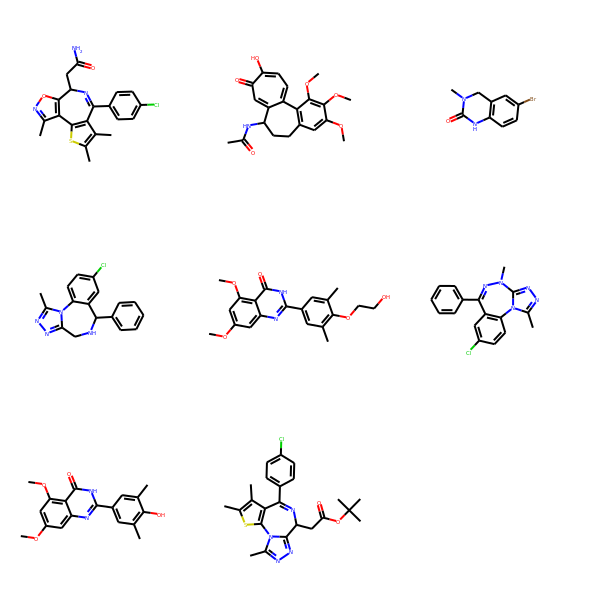

In [10]:
Draw.MolsToGridImage(lig_mols)

In [11]:
receptor = 'pdb/BRD4.pdb'

In [12]:
brd4_data['File'] = ligand_sdf_files[1:]+[ligand_sdf_files[0]]

In [13]:
brd4_data.index

RangeIndex(start=0, stop=8, step=1)

In [14]:
from itertools import combinations
import numpy as np

## ∆G to IC<sub>50</sub>
We assume that it is non-competitive binding. Therefore $K_i=IC_{50}$.  

We know that $\Delta G=RTln(K_i)\Rightarrow K_i=exp(\frac{\Delta G}{RT})=IC_{50}$  
If we are in the body then, we can assume that $T=293 K$ and $R=1.987\times10^{−3
} kcal\dot K^{-1}\dot mol^{-1}$  

In [15]:
R=1.987E-3
T=293
RT=R*T
print(RT)

0.582191


$IC_{50}=exp(\frac{\Delta G}{0.582191 kcal mol^{-1}})$  
$\Rightarrow pIC_{50}=-log_{10}(exp(\frac{\Delta G}{0.582191 kcal mol^{-1}}))$

In [26]:
list_of_comparisons=[]
for idx1, idx2 in combinations(brd4_data.index,2):
    pic50_1 = -np.log10(np.exp(float(brd4_data.iloc[idx1]['Exp ΔG'])/RT))
    pic50_2 = -np.log10(np.exp(float(brd4_data.iloc[idx2]['Exp ΔG'])/RT))
    cls = int(pic50_1 > pic50_2) ## larger IC50 is better
    del_pic = pic50_1 - pic50_2
    comparison = [cls, del_pic, pic50_1, pic50_2, receptor, brd4_data.iloc[idx1]['File'], brd4_data.iloc[idx2]['File']]
    list_of_comparisons.append(comparison)
output_csv = pd.DataFrame(list_of_comparisons,columns=['Cls','ddg', 'dg_lig1', 'dg_lig2','receptor','lig1','lig2'])

In [27]:
output_csv

,Cls,ddg,dg_lig1,dg_lig2,receptor,lig1,lig2
0,0,-0.305846,4.438496,4.744341,pdb/BRD4.pdb,sdf/ligand-3.sdf,sdf/ligand-4.sdf
1,0,-1.081650,4.438496,5.520146,pdb/BRD4.pdb,sdf/ligand-3.sdf,sdf/ligand-5.sdf
2,0,-1.409875,4.438496,5.848371,pdb/BRD4.pdb,sdf/ligand-3.sdf,sdf/ligand-6.sdf
3,0,-1.648584,4.438496,6.087080,pdb/BRD4.pdb,sdf/ligand-3.sdf,sdf/ligand-7.sdf
4,0,-2.267736,4.438496,6.706231,pdb/BRD4.pdb,sdf/ligand-3.sdf,sdf/ligand-8.sdf
5,0,-2.752613,4.438496,7.191109,pdb/BRD4.pdb,sdf/ligand-3.sdf,sdf/ligand-9.sdf
6,0,-3.327007,4.438496,7.765502,pdb/BRD4.pdb,sdf/ligand-3.sdf,sdf/ligand-10.sdf
7,0,-0.775804,4.744341,5.520146,pdb/BRD4.pdb,sdf/ligand-4.sdf,sdf/ligand-5.sdf
8,0,-1.104029,4.744341,5.848371,pdb/BRD4.pdb,sdf/ligand-4.sdf,sdf/ligand-6.sdf
9,0,-1.342738,4.744341,6.087080,pdb/BRD4.pdb,sdf/ligand-4.sdf,sdf/ligand-7.sdf


In [21]:
output_csv.to_csv('brd4_test_set.types', sep=' ',header=False,index=False)